In [2]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text


from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

tools_path = '../helperScripts/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [33]:
# roi_of_interest = 'roi_1'
# roi_of_interest = 'roi_2'
# roi_of_interest  = 'roi_3'
# roi_of_interest = 'run2_roi_2'
roi_of_interest = 'run2_roi_3'


n_cells_per_cluster = 25
clone_scores = pd.read_csv(f'../extractedData/in_vivo/other_rois/clone_scores_{roi_of_interest}_{n_cells_per_cluster}cellspercluster.csv',index_col=0)
# clone_scores = pd.read_csv('../extractedData/in_vivo/clone_scores.csv',index_col=0)
clone_scores['p_val_adj'] = clone_scores['p_val']*len(clone_scores.index)

n_rings =  25
# space_scores = pd.read_csv(f'../extractedData/space_scores_{n_rings}rings.csv',index_col=0)
space_scores = pd.read_csv(f'../extractedData/in_vivo/other_rois/space_scores_{roi_of_interest}_{n_rings}rings_barcoded.csv',index_col=0)
space_scores['p_val_adj'] = space_scores['p_val']*len(space_scores.index)


In [34]:
space_scores

,score,p_val,p_val_adj
gene,,,
AKT1,1.333837,0.087409,9.964670
AXL,2.134345,0.004500,0.512957
BGN,0.724120,0.915174,104.329806
BIRC3,0.869166,0.662445,75.518707
BIRC5,0.700225,0.941588,107.341055
...,...,...,...
VEGFC,1.242771,0.140072,15.968169
WNT5A,0.888411,0.649279,74.017832
YAP1,2.286333,0.000333,0.037997


Number of genes with p-value less than 0.01 and score above 2: 20 total: 114


Text(0, 0.5, 'Ratio of real to permuted delta')

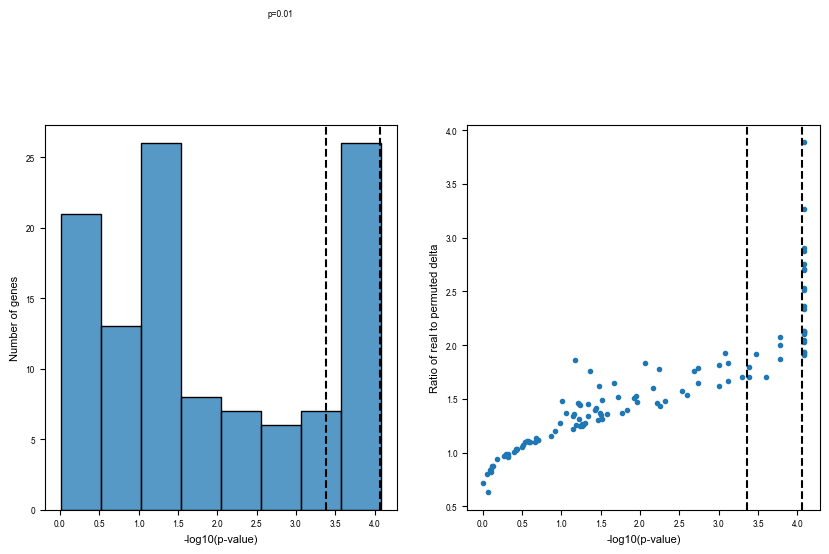

In [35]:
# plot clone scores and p-values]

plt.figure(figsize=(10,5))

## subplot 
plt.subplot(1,2,1)
sns.histplot(-np.log10(clone_scores['p_val']))

plt.axvline(-np.log10(0.01/119),color='k',linestyle='--')
plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.05/119),color='k',linestyle='--')
# plt.axvline(-np.log10(0.1),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')

# number of genes with p-value less than 0.01 and score above 2
print('Number of genes with p-value less than 0.01 and score above 2:',np.sum((clone_scores['p_val'] < 0.01) & (clone_scores['score'] > 2)),'total:',len(clone_scores.index))
# print()

# calculate ratio of real data to average from the permutations
plt.subplot(1,2,2)
plt.scatter(-np.log10(clone_scores['p_val']),clone_scores['score'],marker='.')

plt.axvline(-np.log10(0.05/len(clone_scores.index)),color='k',linestyle='--')
# plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.01/len(clone_scores.index)),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Ratio of real to permuted delta')

# # annotate top genes
# for gene in clone_scores.sort_values('score',ascending=False)[:10].index:
#     plt.text(-np.log10(p_vals[gene]),scores[gene],gene,ha='right')

Number of genes with p-value less than 0.01 and score above 2: 31 total: 114


Text(0, 0.5, 'Ratio of real to permuted delta')

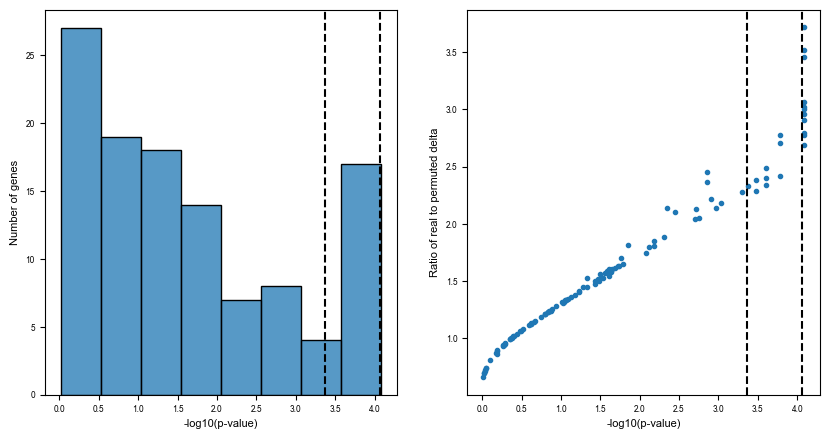

In [36]:
# plot space scores and p-values

plt.figure(figsize=(10,5))

## subplot 
plt.subplot(1,2,1)
sns.histplot(-np.log10(space_scores['p_val']))

plt.axvline(-np.log10(0.01/119),color='k',linestyle='--')
# plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.05/119),color='k',linestyle='--')
# plt.axvline(-np.log10(0.1),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')

# number of genes with p-value less than 0.01 and score above 2
print('Number of genes with p-value less than 0.01 and score above 2:',np.sum((space_scores['p_val'] < 0.01) & (space_scores['score'] > 2)),'total:',len(space_scores.index))
# print()

# calculate ratio of real data to average from the permutations
plt.subplot(1,2,2)
plt.scatter(-np.log10(space_scores['p_val']),space_scores['score'],marker='.')

plt.axvline(-np.log10(0.05/len(space_scores.index)),color='k',linestyle='--')
# plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.01/len(space_scores.index)),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Ratio of real to permuted delta')

# # annotate top genes
# for gene in clone_scores.sort_values('score',ascending=False)[:10].index:
#     plt.text(-np.log10(p_vals[gene]),scores[gene],gene,ha='right')

In [37]:
space_scores[space_scores['p_val_adj'] < 0.01]

,score,p_val,p_val_adj
gene,,,
CAPG,2.902328,0.000083,0.009499
COL9A3,3.716093,0.000083,0.009499
ERBB3,3.023238,0.000083,0.009499
FN1,3.452329,0.000083,0.009499
ITGA3,2.959420,0.000083,0.009499
ITGAV,2.683832,0.000083,0.009499
PDGFA,3.002456,0.000083,0.009499
SOX10,3.515242,0.000083,0.009499
TAFAZZIN,2.793935,0.000083,0.009499


In [38]:
both_scores = pd.merge(clone_scores,space_scores,left_index=True,right_index=True,suffixes=('_clone','_space'))

In [39]:
both_scores[both_scores['p_val_adj_clone'] < 0.01]

,score_clone,p_val_clone,p_val_adj_clone,score_space,p_val_space,p_val_adj_space
gene,,,,,,
AKT1,1.920947,0.000083,0.009499,1.333837,0.087409,9.964670
CAPG,2.510052,0.000083,0.009499,2.902328,0.000083,0.009499
COL9A3,1.904826,0.000083,0.009499,3.716093,0.000083,0.009499
CTNNB1,2.751605,0.000083,0.009499,0.660902,0.968419,110.399800
FGFR1,2.701255,0.000083,0.009499,1.586351,0.023415,2.669278
FN1,2.102087,0.000083,0.009499,3.452329,0.000083,0.009499
HIF1A,1.938395,0.000083,0.009499,1.150541,0.216149,24.640947
HK2,2.128466,0.000083,0.009499,2.048585,0.001750,0.199483
ITGA6,2.131367,0.000083,0.009499,2.487440,0.000250,0.028498


In [40]:
both_scores[both_scores['p_val_adj_space'] < 0.01].count()

score_clone        11
p_val_clone        11
p_val_adj_clone    11
score_space        11
p_val_space        11
p_val_adj_space    11
dtype: int64

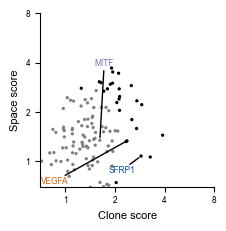

In [41]:
# plot ratio for clone and rings, only plotting genes present in both sets
# common_genes = [gene for gene in scores_ring.index if gene in scores.index]
plt.figure(figsize=(2.25,2.25))

color_list = []

score_cutoff = 2 
p_val_adj_cutoff = 0.01

# color points by p-value and score
for entry in both_scores.index:
    if both_scores['score_clone'].loc[entry] > score_cutoff and both_scores['score_space'].loc[entry] > score_cutoff and both_scores['p_val_adj_clone'].loc[entry] < p_val_adj_cutoff and both_scores['p_val_adj_space'].loc[entry] < p_val_adj_cutoff:
        color_list.append('k')
    elif both_scores['score_clone'].loc[entry] > score_cutoff and both_scores['p_val_adj_clone'].loc[entry] < p_val_adj_cutoff:
        color_list.append('k')
    elif both_scores['p_val_adj_space'].loc[entry] < p_val_adj_cutoff and both_scores['score_space'].loc[entry] > score_cutoff:
        color_list.append('k')
    else:
        color_list.append('gray')



plt.scatter(both_scores['score_clone'],both_scores['score_space'],marker='.',color=color_list,s=7.5)

plt.xlabel('Clone score\n(ratio of true difference to avg. permuted difference)')
plt.ylabel('Space score\n(ratio of true difference to avg. permuted difference)')

plt.xlabel('Clone score')
plt.ylabel('Space score')

# annotate top 5 genes for each using adjust_text

# genes_to_plot = ['VEGFA','SFRP1','MITF','SPARC','ITGA8','MMP11']
# genes_to_plot = ['VEGFA','SFRP1','MITF','SPARC','MMP1','BMP2']
genes_to_plot = ['VEGFA','SFRP1','MITF',
                #  'SPARC'
                 ]
gene_colors = ['b','orange','r','k']

gene_colors = {
                # 'VEGFA':'#5e3c99',
               'VEGFA':'#d95f02', # dark orange
               'SFRP1':'#08519c', # blue
            #    'SPARC':'k',
               
            #    'MITF':'#e66101',
               'MITF':'#7570b3', # purple
               
               }




texts = []



for gene in genes_to_plot:
    texts.append(plt.text(both_scores['score_clone'].loc[gene],both_scores['score_space'].loc[gene],gene,ha='right',c=gene_colors[gene]))

# plt.axvline(2,color='k',linestyle='--',lw=1,zorder=0)
# plt.axhline(2,color='k',linestyle='--',lw=1,zorder=0) 

# plt.axvline(3,color='k',linestyle='--',lw=1,zorder=0)
# plt.axhline(3,color='k',linestyle='--',lw=1,zorder=0) 

# plt.axvline(1,color='gray',linestyle='-',lw=1,zorder=0)
# plt.axhline(1,color='gray',linestyle='-',lw=1,zorder=0) 

# plt.xlim(0.5,4)
# plt.ylim(0.5,4)

# plt.xlim(0.5,8)
# plt.ylim(0.5,8)
plt.yscale('log',base=2)
plt.xscale('log',base=2)

plt.xticks([0.5,1,2,4,8],[0.5,1,2,4,8])
plt.yticks([0.5,1,2,4,8],[0.5,1,2,4,8])

plt.xlim(0.7,8)
plt.ylim(0.7,8)

sns.despine()

# plt.xlim(0,4)
# plt.ylim(0,4)

# plt.xticks([0,1,2,3,4])
# plt.yticks([0,1,2,3,4])


# for gene in scores_ring.sort_values(ascending=False)[:5].index:
#     texts.append(plt.text(scores[gene],scores_ring[gene],gene,ha='right'))

# for gene in scores.sort_values(ascending=False)[:10].index:
#     if gene not in scores_ring.sort_values(ascending=False)[:10].index:
#         texts.append(plt.text(scores[gene],scores_ring[gene],gene,ha='right'))

# for gene in scores.sort_values(ascending=True)[:10].index:
#     if gene in scores_ring.sort_values(ascending=True)[:10].index:
#         if gene != 'ENSMUSG00000071361':
#             texts.append(plt.text(scores[gene],scores_ring[gene],gene,ha='right'))

adjust_text(texts,x=both_scores['score_clone'],y=both_scores['score_space'],force_static=(2,2),arrowprops=dict(arrowstyle='-',color='k'))

plt.savefig(f'../graphs/other_rois/{roi_of_interest}_clone_v_space_scores.pdf',bbox_inches='tight',pad_inches=0,transparent=True)


In [44]:
both_scores[both_scores['score_clone'] < 0.5]

,score_clone,p_val_clone,p_val_adj_clone,score_space,p_val_space,p_val_adj_space
gene,,,,,,


In [45]:
both_scores[(both_scores['score_clone'] >2) & (both_scores['score_space'] < 2)]

,score_clone,p_val_clone,p_val_adj_clone,score_space,p_val_space,p_val_adj_space
gene,,,,,,
CTNNB1,2.751605,0.000083,0.009499,0.661578,0.967169,110.257312
FGFR1,2.701255,0.000083,0.009499,1.585939,0.024915,2.840263
FOSL1,2.005405,0.000167,0.018998,1.534830,0.031831,3.628698
MLANA,2.334383,0.000083,0.009499,1.317779,0.093909,10.705608
MYC,2.031995,0.000083,0.009499,0.742080,0.895425,102.078493
NCAM1,2.077434,0.000167,0.018998,1.526222,0.030581,3.486209
PRRX1,2.528504,0.000083,0.009499,1.808862,0.007249,0.826431
SERPINF1,3.270610,0.000083,0.009499,1.060236,0.330389,37.664361
SFRP1,2.875759,0.000083,0.009499,1.083690,0.293392,33.446713


In [12]:
both_scores[(both_scores['score_clone'] < 1.1) & (both_scores['score_space'] > 1.1)]

,score_clone,p_val_clone,p_val_adj_clone,score_space,p_val_space,p_val_adj_space
gene,,,,,,
AXL,1.011675,0.385718,45.900425,1.588657,0.052329,6.227148
BIRC3,0.776023,0.699192,83.203816,1.932631,0.007749,0.922173
BMP4,0.932243,0.645446,76.808099,1.485674,0.038663,4.600950
KIT,0.877353,0.718690,85.524123,1.266873,0.127406,15.161320
MERTK,0.965253,0.548538,65.275977,1.777187,0.007416,0.882510
MMP11,0.912489,0.623948,74.249813,1.218025,0.170986,20.347304
NANOG,1.014654,0.478710,56.966503,1.259600,0.134322,15.984335
NGFR,0.925529,0.418215,49.767603,1.414480,0.067244,8.002083
OASL,0.772293,0.621865,74.001917,1.179027,0.209149,24.888759
